# Train A Shape Classifier Model



In [ ]:
#create simple plots and visualizations
import matplotlib.pyplot as plt

#use common neural network operations like activations and loss functions.
import torch.nn.functional as F

#ImageIO:open, edit, and save image files 
from PIL import Image



In [ ]:
# read and write data in JSON format, simple for configs and annotations.
import json
import os

train_data_root = "../datasets/train"
test_data_root = "../datasets/test"

In [2]:
import sys, torch
print(sys.executable)
print("torch version:", torch.__version__)


d:\MasterSRC\inOutCampusPractice\silverpond_enter_project\intern-skills-silverpond\.venv\Scripts\python.exe
torch version: 2.9.1+cpu


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations (including resizing and normalization)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (black and white images)
    transforms.Resize((64, 64)),  # Resize images to 64x64 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images (mean=0.5, std=0.5 for grayscale)
])

# Load the dataset
train_dataset = datasets.ImageFolder(root=train_data_root, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check class names (optional)
print(f'Classes: {train_dataset.classes}')

# 2. Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        # self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 classes: circle, triangle, rectangle
        
    def forward(self, x):
        x = F.relu(self.conv1(x))   # First Conv Layer
        x = F.max_pool2d(x, 2)      # Max Pooling
        x = F.relu(self.conv2(x))   # Second Conv Layer
        x = F.max_pool2d(x, 2)      # Max Pooling
        x = x.view(x.size(0), -1)   # Flatten
        x = F.relu(self.fc1(x))     # Fully Connected Layer 1
        x = self.fc2(x)             # Fully Connected Layer 2 (output)
        return x

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # accuracy = 0 * correct / total
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')


Classes: ['circle', 'diamond', 'triangle']


# Train

In [5]:
train_model(model, train_loader, criterion, optimizer, epochs=15)

Epoch [1/15], Loss: 1.1089, Accuracy: 37.71%
Epoch [2/15], Loss: 0.9991, Accuracy: 48.71%
Epoch [3/15], Loss: 0.9009, Accuracy: 57.00%
Epoch [4/15], Loss: 0.7459, Accuracy: 65.71%
Epoch [5/15], Loss: 0.6041, Accuracy: 74.14%
Epoch [6/15], Loss: 0.4083, Accuracy: 85.14%
Epoch [7/15], Loss: 0.2914, Accuracy: 90.14%
Epoch [8/15], Loss: 0.2134, Accuracy: 91.86%
Epoch [9/15], Loss: 0.1364, Accuracy: 96.43%
Epoch [10/15], Loss: 0.0874, Accuracy: 98.00%
Epoch [11/15], Loss: 0.0565, Accuracy: 99.57%
Epoch [12/15], Loss: 0.0328, Accuracy: 99.57%
Epoch [13/15], Loss: 0.0186, Accuracy: 100.00%
Epoch [14/15], Loss: 0.0130, Accuracy: 100.00%
Epoch [15/15], Loss: 0.0064, Accuracy: 100.00%


# Test 

In [ ]:
# Import the main PyTorch library for working with tensors and neural networks.
import torch
# Import the functional API from torch.nn as F for convenient neural network operations.
import torch.nn.functional as F

# Use inference_mode decorator to run this function without gradient tracking for faster, memory-efficient testing.
@torch.inference_mode()
# Define a function to evaluate the model on the test set using a given data loader.
def test(model, test_loader):
    """Evaluate model on test set and print per-class & macro Precision/Recall/F1."""
    
    # Get the device (CPU or GPU) that the model is using so we can send data to the same place.
    device = next(model.parameters()).device

    # Put the model into evaluation mode so layers like dropout and batchnorm behave correctly for testing.
    model.eval()
    # Create an empty list to store predictions for all test samples.
    all_preds = []
    # Create an empty list to store true labels for all test samples.
    all_labels = []

    # Loop over all batches from the test loader to process the entire test dataset.
    for images, labels in test_loader:
        # Move the input images to the same device as the model.
        images = images.to(device)
        # Move the labels to the same device as the model.
        labels = labels.to(device)

        # Run the model on this batch of images to get class scores for each sample.
        outputs = model(images)
        # Take the index of the maximum score along the class dimension as the predicted class for each sample.
        _, preds = torch.max(outputs, dim=1)

        # Store this batch's predictions on the CPU so we can combine them later.
        all_preds.append(preds.cpu())
        # Store this batch's true labels on the CPU so we can combine them later.
        all_labels.append(labels.cpu())

    # Concatenate all prediction tensors from each batch into one long tensor for the whole test set.
    all_preds = torch.cat(all_preds)
    # Concatenate all label tensors from each batch into one long tensor for the whole test set.
    all_labels = torch.cat(all_labels)

    # Get the number of classes from the dataset so we know how big the confusion matrix should be.
    num_classes = len(test_loader.dataset.classes)
    # Get the list of class names from the dataset so we can print human-readable results.
    class_names = test_loader.dataset.classes

    # Create an empty confusion matrix where rows are true labels and columns are predicted labels.
    conf_mat = torch.zeros((num_classes, num_classes), dtype=torch.int64)

    # Loop over all true–predicted pairs to fill in the confusion matrix counts.
    for t, p in zip(all_labels, all_preds):
        # Increase the counter for this (true class, predicted class) position by one.
        conf_mat[t, p] += 1

    # Take the diagonal elements of the confusion matrix as true positives for each class.
    TP = conf_mat.diag().float()
    # Sum over columns to get how many samples were predicted as each class.
    pred_counts = conf_mat.sum(dim=0).float()
    # Sum over rows to get how many samples actually belong to each class.
    true_counts = conf_mat.sum(dim=1).float()

    # Compute per-class precision as TP divided by predicted positives with a small epsilon to avoid division by zero.
    precision_per_class = TP / (pred_counts + 1e-8)
    # Compute per-class recall as TP divided by actual positives with a small epsilon to avoid division by zero.
    recall_per_class    = TP / (true_counts + 1e-8)
    # Compute per-class F1 score as the harmonic mean of precision and recall with a small epsilon in the denominator.
    f1_per_class        = 2 * precision_per_class * recall_per_class / (
        precision_per_class + recall_per_class + 1e-8
    )

    # Compute the macro (unweighted) average precision across all classes and convert to a Python float.
    macro_precision = precision_per_class.mean().item()
    # Compute the macro (unweighted) average recall across all classes and convert to a Python float.
    macro_recall    = recall_per_class.mean().item()
    # Compute the macro (unweighted) average F1 score across all classes and convert to a Python float.
    macro_f1        = f1_per_class.mean().item()

    # Print the confusion matrix so we can see how predictions are distributed across classes.
    print("Confusion matrix:\n", conf_mat.numpy())
    print()

    # Loop over each class index and name to print its individual metrics.
    for i, name in enumerate(class_names):
        # Print precision, recall, and F1 score for this specific class in a formatted line.
        print(
            f"Class '{name}': "
            f"P={precision_per_class[i]:.3f}, "
            f"R={recall_per_class[i]:.3f}, "
            f"F1={f1_per_class[i]:.3f}"
        )

    print()
    # Print the macro-averaged precision, recall, and F1 score as a summary of overall performance.
    print(
        f"Macro Precision: {macro_precision:.3f}, "
        f"Macro Recall: {macro_recall:.3f}, "
        f"Macro F1: {macro_f1:.3f}"
    )


In [ ]:
# Call the test function to evaluate the trained model on the test_loader and print all metrics.

test(model, test_loader)


Confusion matrix:
 [[68 18  3]
 [29 78 10]
 [ 5  4 85]]

Class 'circle': P=0.667, R=0.764, F1=0.712
Class 'diamond': P=0.780, R=0.667, F1=0.719
Class 'triangle': P=0.867, R=0.904, F1=0.885

Macro Precision: 0.771, Macro Recall: 0.778, Macro F1: 0.772


# Show Predictions


In [ ]:
# Import the pyplot module from Matplotlib to create simple visualizations like showing images and adding titles (very beginner-friendly for plotting).
import matplotlib.pyplot as plt
# Import the Image class from the Pillow (PIL) library so we can easily open and handle image files.
from PIL import Image
# Import the functional API from PyTorch as F so we can conveniently apply functions like softmax to model outputs.
import torch.nn.functional as F

# Use inference_mode so this function runs without tracking gradients, which is faster and safer for pure prediction.
@torch.inference_mode()
# Define a helper function that runs the model on a single image and visualizes the prediction result.
def show_prediction(
    model,
    image_path: str,
    transform,
    class_names,
    true_label_idx: int | None = None,
    ax=None,
):
    """
    Make predictions for a single image and visualize the results.

    `model: nn.Module` The trained CNN model.

    `image_path: str` The path to the input image.

    `transform: torchvision.transforms.Compose` The exact same transform as during training/testing.

    `class_names: list[str]` A list of class names, e.g., ['circle', 'diamond', 'triangle'].

    `true_label_idx: int, optional` The index of the true label (if any, used to display 'GT→Pred').

    If None, only Pred is displayed.

    `ax: matplotlib.axes.Axes, optional` Pass in an existing subplot axis; if None, a new figure is created.
     """

    # Get the device (CPU or GPU) where the model’s parameters live so we can send data to the same place.
    device = next(model.parameters()).device
    # Put the model into evaluation mode so layers like dropout and batchnorm behave correctly for inference.
    model.eval()

    # Load the image from disk as a PIL image and convert it to RGB format for consistent processing.
    img_pil = Image.open(image_path).convert("RGB")

    # Apply the same preprocessing as in training, add a batch dimension, and move the tensor to the model’s device.
    img_tensor = transform(img_pil).unsqueeze(0).to(device)   # [1, C, H, W]

    # Run a forward pass through the model to get raw class scores (logits) for this image.
    logits = model(img_tensor)                     # [1, num_classes]
    # Apply softmax to convert logits into probabilities and move the result back to CPU.
    probs = F.softmax(logits, dim=1).squeeze(0).cpu()  # [num_classes]

    # Find the index of the class with the highest probability as the predicted label.
    pred_idx = int(torch.argmax(probs))
    # Get the confidence (probability) of the predicted class as a plain Python float.
    pred_conf = float(probs[pred_idx])  # 0~1
    # Look up the human-readable class name for the predicted class index.
    pred_name = class_names[pred_idx]

    # If a ground-truth label is provided, prepare a title showing “GT → Pred”; otherwise show only the prediction.
    if true_label_idx is not None:
        # Get the human-readable name of the ground-truth class.
        true_name = class_names[true_label_idx]
        # Build a title string that shows ground truth, prediction, and confidence percentage.
        title = f"{true_name} \u2192 {pred_name} ({pred_conf:.2%})"
    else:
        # Build a title string that shows only the predicted class and its confidence.
        title = f"{pred_name} ({pred_conf:.2%})"

    # Track whether this function needs to create its own figure for plotting.
    created_fig = False
    # If no Axes object is provided, create a new figure and axis for displaying the image.
    if ax is None:
        fig, ax = plt.subplots()
        created_fig = True

    # Show the original PIL image on the selected axis.
    ax.imshow(img_pil)
    # Hide the axis ticks and frame for a cleaner image display.
    ax.axis("off")
    # Set the title above the image to show prediction information.
    ax.set_title(title)

    # If this function created the figure, display it immediately so the user can see the result.
    if created_fig:
        plt.show()


Picked indices: [0, 89, 206]
Class names: ['circle', 'diamond', 'triangle']


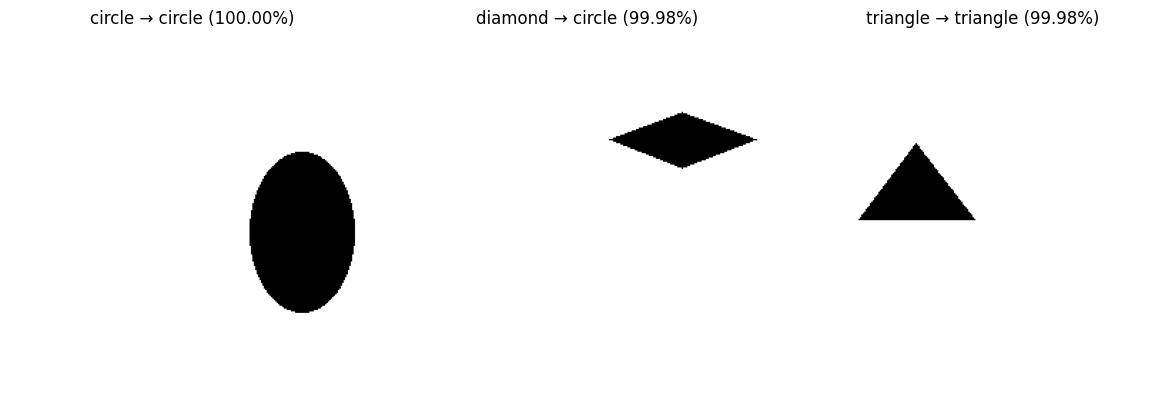

In [ ]:
# Small helper: pick one sample from each class in the test_dataset for later visualization.
# Get the total number of classes from the dataset so we know how many samples to pick.
num_classes = len(test_dataset.classes)
# Store the human-readable class names from the dataset for later display.
class_names = test_dataset.classes

# Keep a list of indices where we first see each class in the dataset.
# Initialize an empty list that will store the chosen sample index for each class.
picked_indices = []
#Use a Python set to record which class labels we have already seen (fast and beginner-friendly).
seen_classes = set()

# Loop over all samples with their index so we can grab the first occurrence of each class.
for idx, (_, label_idx) in enumerate(test_dataset.samples):
    # If this class label has not been seen before, we record this index as its representative sample.
    if label_idx not in seen_classes:
        # Add the new class label to the set so we do not pick it again.
        seen_classes.add(label_idx)
        # Save the index of this sample as the chosen example for this class.
        picked_indices.append(idx)
    # If we have already picked one sample for every class, we can stop the loop early to save time.
    if len(picked_indices) == num_classes:
        break

# Print out the indices we picked so we can quickly check which samples are used.
print("Picked indices:", picked_indices)
# Print the class names list so we can see the mapping from index to class label.
print("Class names:", class_names)

# Draw one image for each class, with a title showing “GT → Pred (conf%)”.
# Create a row of subplots, one axis per class, with a figure size that scales nicely with num_classes.
fig, axes = plt.subplots(1, num_classes, figsize=(4 * num_classes, 4))

# Loop over each subplot axis and its corresponding picked sample index.
for ax, sample_idx in zip(axes, picked_indices):
    # Get the image path and its label index from the test_dataset’s internal samples list.
    img_path, label_idx = test_dataset.samples[sample_idx]

    # Call our helper to run the model on this image and draw the prediction on the given axis.
    show_prediction(
        model,
        image_path=img_path,
        transform=transform,
        class_names=class_names,
        true_label_idx=label_idx,  # Pass the ground-truth label so the title can show “GT → Pred”.
        ax=ax,
    )

# Adjust subplot spacing so titles and images do not overlap and everything looks clean.
plt.tight_layout()
# Finally display the whole figure so we can see one prediction example for each class.
plt.show()
